## Get Pricing and Weather Data

In [7]:
import requests
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime, timedelta


First, let's make sure the Wall Street Journal site is working.

In [9]:
# testing for site status

url = 'http://www.wsj.com/mdc/public/page/2_3020-cashprices-20151001.html'

response = requests.get(url)
response.status_code

200

Next, use pandas to easily read in all the tables on the page.

In [10]:
# preview page tables

tables = pd.read_html(url)
df = tables[1] # there are 3 tables on the page
df.head(10)

,0,1,2,3,4,5
0,NaN,Bid,Ask,Thurs Price,Previous,Year Ago
1,Energy,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,"Propane, tet, Mont Belvieu, Texas, gal.-G",...,...,0.4743,0.4666,1.0514
4,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN
6,"Butane, normal, Mont Belvieu, Texas, gal.-G",...,...,0.6370,0.6245,1.2280
7,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN
9,"Natural Gas, Henry Hub-I",...,...,2.370,2.470,3.990


There appears to be some empty rows without any data, and the header row is showing up as the first observation row.  Let's remove all the NaN rows, rename the columns, and add in a column for the spot price date.

In [11]:
# rename dataframe columns
df.columns = ["Commodity","Bid","Ask","Price","Previous","YearAgo"]

df.dropna(inplace=True)

# insert date column
df["Date"] = "20151001"

# reset index for removed NaN rows
df.reset_index(drop=True,inplace=True)

df.head(10)

,Commodity,Bid,Ask,Price,Previous,YearAgo,Date
0,"Propane, tet, Mont Belvieu, Texas, gal.-G",...,...,0.4743,0.4666,1.0514,20151001
1,"Butane, normal, Mont Belvieu, Texas, gal.-G",...,...,0.6370,0.6245,1.2280,20151001
2,"Natural Gas, Henry Hub-I",...,...,2.370,2.470,3.990,20151001
3,"Natural Gas, Transco Zone 3, $ per Mmbtu-I",...,...,2.350,2.440,3.900,20151001
4,"Natural Gas, Transco Zone 6 NY, $ per MMBtu-I",...,...,2.130,2.440,1.910,20151001
5,"Natural Gas, Panhandle East, $ per MMBtu-I",...,...,2.270,2.300,3.750,20151001
6,"Natural Gas, Opal, $ per MMBtu-I",...,...,2.330,2.390,3.790,20151001
7,"Natural Gas, Marcellus NE PA, $ per MMBtu-I",...,...,0.700,0.850,1.850,20151001
8,"Natural Gas, Haynesville N. LA, $ per MMBtu-I",...,...,2.360,2.410,3.880,20151001
9,"Coal, Central Appalachia, 12,500 Btu, 1.2 SO2-R,W",...,...,48.650,48.650,54.590,20151001


That looks better.  
I'm only interested in the spot price for the first few natural gas hubs, so let's also clean up the excess information.

In [12]:
# separate out only certain natural gas hub rows, and price and date cols

df_Henry = df.iloc[2,[0,3,6]]
df_TranscoZ3 = df.iloc[3,[0,3,6]]
df_TranscoZ6 = df.iloc[4,[0,3,6]]
df_PEPL = df.iloc[5,[0,3,6]]
df_Opal = df.iloc[6,[0,3,6]]

print(df_Henry, df_TranscoZ3, df_TranscoZ6, df_PEPL, df_Opal)

Commodity    Natural Gas, Henry Hub-I
Price                           2.370
Date                         20151001
Name: 2, dtype: object Commodity    Natural Gas, Transco Zone 3, $ per Mmbtu-I
Price                                             2.350
Date                                           20151001
Name: 3, dtype: object Commodity    Natural Gas, Transco Zone 6 NY, $ per MMBtu-I
Price                                                2.130
Date                                              20151001
Name: 4, dtype: object Commodity    Natural Gas, Panhandle East, $ per MMBtu-I
Price                                             2.270
Date                                           20151001
Name: 5, dtype: object Commodity    Natural Gas, Opal, $ per MMBtu-I
Price                                   2.330
Date                                 20151001
Name: 6, dtype: object


Now that's basically what I want for all the dates in my date range.  
So let's make a function that will go to each url for each date, and pull out that information.

In [13]:
def scrape_commodity(begin_date, end_date):
    current_date = datetime.strptime(begin_date, "%Y-%m-%d")
    # add one to make loop end on the end date
    end_date = datetime.strptime(end_date, "%Y-%m-%d")+timedelta(days=1) 

    lookup_URL = 'http://www.wsj.com/mdc/public/page/2_3020-cashprices-{}.html'

    while current_date != end_date:
        try:
            formatted_lookup_URL = lookup_URL.format(current_date.strftime("%Y%m%d"))
            #print(formatted_lookup_URL)
            
            tables = pd.read_html(formatted_lookup_URL)
            df = tables[1] #there are 3 tables on the page
            df.columns = ["Commodity","Bid","Ask","Price","Previous","YearAgo"]
            df.dropna(inplace=True)
            df["Date"] = current_date
            df.reset_index(drop=True,inplace=True)
            
            ls_Henry.append(df.iloc[2,[0,3,6]].tolist())
            ls_TranscoZ3.append(df.iloc[3,[0,3,6]].tolist())
            ls_TranscoZ6.append(df.iloc[4,[0,3,6]].tolist())
            ls_PEPL.append(df.iloc[5,[0,3,6]].tolist())
            ls_Opal.append(df.iloc[6,[0,3,6]].tolist())

            #print(ls_Henry)
            
            time.sleep(.5+2*random.random())

            current_date += timedelta(days=1)
            
        except:
            current_date += timedelta(days=1)

In [14]:
ls_Henry = []
ls_TranscoZ3 = []
ls_TranscoZ6 = []
ls_PEPL = []
ls_Opal = []

scrape_commodity('2015-10-01','2018-09-30')

I've now scraped all the data for each hub into its own list, and next, I'll make them each into their own dataframe for additional pre-processing and some preliminary EDA.

In [17]:
headers = ["Commodity","Price","Date"]

df_Henry = pd.DataFrame(ls_Henry, columns=headers)
df_Henry.head(10)

,Commodity,Price,Date
0,"Natural Gas, Henry Hub-I",2.370,2015-10-01
1,"Natural Gas, Henry Hub-I",2.260,2015-10-02
2,"Natural Gas, Henry Hub-I",2.320,2015-10-05
3,"Natural Gas, Henry Hub-I",2.350,2015-10-06
4,"Natural Gas, Henry Hub-I",2.460,2015-10-07
5,"Natural Gas, Henry Hub-I",2.440,2015-10-08
6,"Natural Gas, Henry Hub-I",2.360,2015-10-09
7,"Natural Gas, Henry Hub-I",2.440,2015-10-12
8,"Natural Gas, Henry Hub-I",2.430,2015-10-13
9,"Natural Gas, Henry Hub-I",2.440,2015-10-14


In [18]:
df_Henry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 773 entries, 0 to 772
Data columns (total 3 columns):
Commodity    773 non-null object
Price        773 non-null object
Date         773 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 18.2+ KB


In [27]:
df_Henry['Price'] = pd.to_numeric(df_Henry['Price'], errors='coerce')
df_Henry['Log_Price'] = np.log(df_Henry.Price)

In [20]:
df_Henry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 773 entries, 0 to 772
Data columns (total 3 columns):
Commodity    773 non-null object
Price        746 non-null float64
Date         773 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 18.2+ KB


Let's take a look at the prices on some plots.

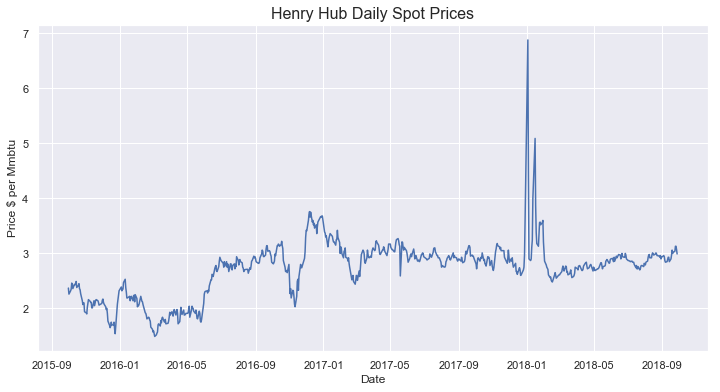

In [160]:

sns.lineplot(x = df_Henry['Date'], y = df_Henry['Price'])
sns.set(rc={'figure.figsize':(12,6)})
plt.title("Henry Hub Daily Spot Prices", fontsize=16)
plt.ylabel("Price $ per Mmbtu")
#g.set_xticklabels(rotation=30)
plt.show();

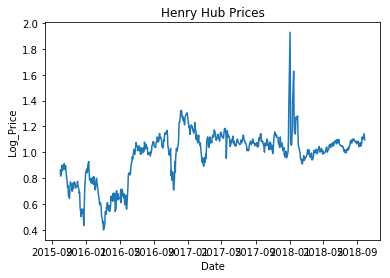

In [28]:
henry = sns.lineplot(x = df_Henry['Date'], y = df_Henry['Log_Price'])
henry.set_title("Henry Hub Prices");

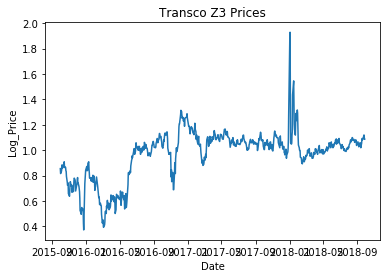

In [29]:
df_TranscoZ3 = pd.DataFrame(ls_TranscoZ3, columns=headers)

df_TranscoZ3['Price'] = pd.to_numeric(df_TranscoZ3['Price'], errors='coerce')
df_TranscoZ3['Log_Price'] = np.log(df_TranscoZ3.Price)

transcoz3 = sns.lineplot(x = df_TranscoZ3['Date'], y = df_TranscoZ3['Log_Price'])

transcoz3.set_title("Transco Z3 Prices");

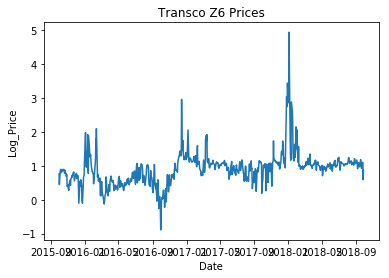

In [33]:
df_TranscoZ6 = pd.DataFrame(ls_TranscoZ6, columns=headers)

df_TranscoZ6['Price'] = pd.to_numeric(df_TranscoZ6['Price'], errors='coerce')
df_TranscoZ6['Log_Price'] = np.log(df_TranscoZ6.Price)

transcoz6 = sns.lineplot(x = df_TranscoZ6['Date'], y = df_TranscoZ6['Log_Price'])

transcoz6.set_title("Transco Z6 Prices");

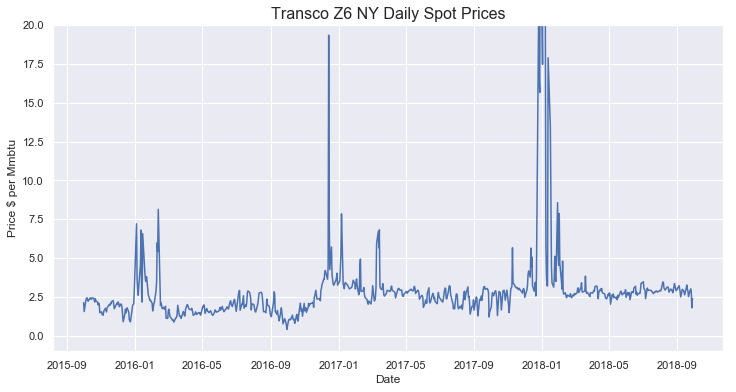

In [169]:

sns.lineplot(x = df_TranscoZ6['Date'], y = df_TranscoZ6['Price'])
sns.set(rc={'figure.figsize':(12,6)})
plt.title("Transco Z6 NY Daily Spot Prices", fontsize=16)
plt.ylabel("Price $ per Mmbtu")
plt.ylim(-1, 20)
#g.set_xticklabels(rotation=30)
plt.show();

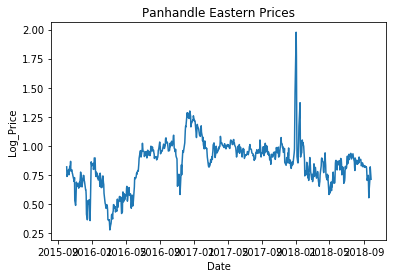

In [32]:
df_PEPL = pd.DataFrame(ls_PEPL, columns=headers)

df_PEPL['Price'] = pd.to_numeric(df_PEPL['Price'], errors='coerce')
df_PEPL['Log_Price'] = np.log(df_PEPL.Price)

pepl = sns.lineplot(x = df_PEPL['Date'], y = df_PEPL['Log_Price'])

pepl.set_title("Panhandle Eastern Prices");

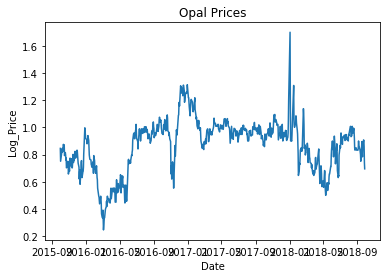

In [31]:
df_Opal = pd.DataFrame(ls_Opal, columns=headers)

df_Opal['Price'] = pd.to_numeric(df_Opal['Price'], errors='coerce')
df_Opal['Log_Price'] = np.log(df_Opal.Price)

opal = sns.lineplot(x = df_Opal['Date'], y = df_Opal['Log_Price'])

opal.set_title("Opal Prices");

Check how many entries there are for each hub and make sure they are all consistent.  This will make concatenating the weather data much easier.

In [48]:
#CHECK .info FOR ALL HUBS

#df_Henry.info()
#df_TranscoZ3.info()
#df_TranscoZ6.info()
#df_PEPL.info()
df_Opal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 4 columns):
Commodity    747 non-null object
Price        747 non-null float64
Date         747 non-null datetime64[ns]
Log_Price    747 non-null float64
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 23.4+ KB


In [43]:
#REMOVE NAN ROWS

df_Henry.dropna(inplace=True)
df_Henry.reset_index(drop=True,inplace=True)

df_TranscoZ3.dropna(inplace=True)
df_TranscoZ3.reset_index(drop=True,inplace=True)

df_TranscoZ6.dropna(inplace=True)
df_TranscoZ6.reset_index(drop=True,inplace=True)

df_PEPL.dropna(inplace=True)
df_PEPL.reset_index(drop=True,inplace=True)

df_Opal.dropna(inplace=True)
df_Opal.reset_index(drop=True,inplace=True)


## Getting weather data

The following sections use the Dark Sky API https://darksky.net/dev to gather high and low temperatures for locations near select natural gas hubs.

You will need your own secret key.

In [49]:
from darksky import forecast #https://pypi.org/project/darkskylib/

In [50]:
# personal secret Dark Sky API key

key = 'REPLACE THIS STRING WITH YOUR PERSONAL KEY'

Dark Sky uses latitudes and longitudes, so I looked up the coordinates for each hub's nearest physical location.

In [51]:
latlong_henry = 29.9583, -92.036
latlong_transcoz3 = 30.7611, -93.3389
latlong_transcoz6 = 40.622, -74.2446
latlong_pepl = 37.8989, -97.7828
latlong_opal = 42.0703, -110.5215


I decided to pull the following information for each location: daily low temperature, daily high temperature, the precipitation type (if any), and the amount of snow (if any).

In [52]:
lowtemps_henry = []
lowtemps_transcoz3 = []
lowtemps_transcoz6 = []
lowtemps_pepl = []
lowtemps_opal = []

hitemps_henry = []
hitemps_transcoz3 = []
hitemps_transcoz6 = []
hitemps_pepl = []
hitemps_opal = []

ptype_henry = []
ptype_transcoz3 = []
ptype_transcoz6 = []
ptype_pepl = []
ptype_opal = []

snowamt_henry = []
snowamt_transcoz3 = []
snowamt_transcoz6 = []
snowamt_pepl = []
snowamt_opal = []


In [53]:
for d in df_Opal['Date']:
    #get low temps for all hubs
    try:
        lowtemps_henry.append(forecast(key, *latlong_henry, d.strftime("%s"))['daily']['data'][0]['temperatureLow'])
    except:
        lowtemps_henry.append("")
    try:
        lowtemps_transcoz3.append(forecast(key, *latlong_transcoz3, d.strftime("%s"))['daily']['data'][0]['temperatureLow'])
    except:
        lowtemps_transcoz3.append("")
    try:
        lowtemps_transcoz6.append(forecast(key, *latlong_transcoz6, d.strftime("%s"))['daily']['data'][0]['temperatureLow'])
    except:
        lowtemps_transcoz6.append("")
    try:
        lowtemps_pepl.append(forecast(key, *latlong_pepl, d.strftime("%s"))['daily']['data'][0]['temperatureLow'])
    except:
        lowtemps_pepl.append("")
    try:
        lowtemps_opal.append(forecast(key, *latlong_opal, d.strftime("%s"))['daily']['data'][0]['temperatureLow'])
    except:
        lowtemps_opal.append("")
        
    #get high temps for all hubs
    try:
        hitemps_henry.append(forecast(key, *latlong_henry, d.strftime("%s"))['daily']['data'][0]['temperatureHigh'])
    except:
        hitemps_henry.append("")
    try:
        hitemps_transcoz3.append(forecast(key, *latlong_transcoz3, d.strftime("%s"))['daily']['data'][0]['temperatureHigh'])
    except:
        hitemps_transcoz3.append("")
    try:
        hitemps_transcoz6.append(forecast(key, *latlong_transcoz6, d.strftime("%s"))['daily']['data'][0]['temperatureHigh'])
    except:
        hitemps_transcoz6.append("")
    try:
        hitemps_pepl.append(forecast(key, *latlong_pepl, d.strftime("%s"))['daily']['data'][0]['temperatureHigh'])
    except:
        hitemps_pepl.append("")
    try:
        hitemps_opal.append(forecast(key, *latlong_opal, d.strftime("%s"))['daily']['data'][0]['temperatureHigh'])
    except:
        hitemps_opal.append("")
    
    #get type of precipitation
    try:
        ptype_henry.append(forecast(key, *latlong_henry, d.strftime("%s"))['daily']['data'][0]['precipType'])
    except:
        ptype_henry.append("")
    try:
        ptype_transcoz3.append(forecast(key, *latlong_transcoz3, d.strftime("%s"))['daily']['data'][0]['precipType'])
    except:
        ptype_transcoz3.append("")
    try:
        ptype_transcoz6.append(forecast(key, *latlong_transcoz6, d.strftime("%s"))['daily']['data'][0]['precipType'])
    except:
        ptype_transcoz6.append("")
    try:
        ptype_pepl.append(forecast(key, *latlong_pepl, d.strftime("%s"))['daily']['data'][0]['precipType'])
    except:
        ptype_pepl.append("")
    try:
        ptype_opal.append(forecast(key, *latlong_opal, d.strftime("%s"))['daily']['data'][0]['precipType'])
    except:
        ptype_opal.append("")
    
    #get accumulation of snow
    try:
        snowamt_henry.append(forecast(key, *latlong_henry, d.strftime("%s"))['daily']['data'][0]['precipAccumulation'])
    except:
        snowamt_henry.append("")
    try:
        snowamt_transcoz3.append(forecast(key, *latlong_transcoz3, d.strftime("%s"))['daily']['data'][0]['precipAccumulation'])
    except:
        snowamt_transcoz3.append("")
    try:
        snowamt_transcoz6.append(forecast(key, *latlong_transcoz6, d.strftime("%s"))['daily']['data'][0]['precipAccumulation'])
    except:
        snowamt_transcoz6.append("")
    try:
        snowamt_pepl.append(forecast(key, *latlong_pepl, d.strftime("%s"))['daily']['data'][0]['precipAccumulation'])
    except:
        snowamt_pepl.append("")
    try:
        snowamt_opal.append(forecast(key, *latlong_opal, d.strftime("%s"))['daily']['data'][0]['precipAccumulation'])
    except:
        snowamt_opal.append("")
    
    

In [103]:
# Henry Hub was missing data for one day, so I removed it to maintain consistency among hubs

print(df_Henry.iloc[559])
print(df_Opal.iloc[559])


Commodity    Natural Gas, Henry Hub-I
Price                            6.88
Date              2018-01-03 00:00:00
Log_Price                     1.92862
Name: 559, dtype: object
Commodity      Natural Gas, Opal, $ per MMBtu-I
Price                                      4.99
Date                        2018-01-02 00:00:00
Log_Price                               1.60744
Low_Temp                                   3.86
Hi_Temp                                   30.67
Precip_Type                                    
Snow_Amt                                       
Name: 559, dtype: object


In [ ]:
# cleaning the Henry Hub data

del lowtemps_henry[559]
del hitemps_henry[559]
del ptype_henry[559]
del snowamt_henry[559]

Now that everything is cleaned and lined up, let's combine the pricing data with the weather data.

In [105]:
# combining weather data with pricing data

df_Henry['Low_Temp'] = np.asarray(lowtemps_henry)
df_Henry['Hi_Temp'] = np.asarray(hitemps_henry)
df_Henry['Precip_Type'] = np.asarray(ptype_henry)
df_Henry['Snow_Amt'] = np.asarray(snowamt_henry)

df_TranscoZ3['Low_Temp'] = np.asarray(lowtemps_transcoz3)
df_TranscoZ3['Hi_Temp'] = np.asarray(hitemps_transcoz3)
df_TranscoZ3['Precip_Type'] = np.asarray(ptype_transcoz3)
df_TranscoZ3['Snow_Amt'] = np.asarray(snowamt_transcoz3)

df_TranscoZ6['Low_Temp'] = np.asarray(lowtemps_transcoz6)
df_TranscoZ6['Hi_Temp'] = np.asarray(hitemps_transcoz6)
df_TranscoZ6['Precip_Type'] = np.asarray(ptype_transcoz6)
df_TranscoZ6['Snow_Amt'] = np.asarray(snowamt_transcoz6)

df_PEPL['Low_Temp'] = np.asarray(lowtemps_pepl)
df_PEPL['Hi_Temp'] = np.asarray(hitemps_pepl)
df_PEPL['Precip_Type'] = np.asarray(ptype_pepl)
df_PEPL['Snow_Amt'] = np.asarray(snowamt_pepl)

df_Opal['Low_Temp'] = np.asarray(lowtemps_opal)
df_Opal['Hi_Temp'] = np.asarray(hitemps_opal)
df_Opal['Precip_Type'] = np.asarray(ptype_opal)
df_Opal['Snow_Amt'] = np.asarray(snowamt_opal)


In [107]:
df_Henry.tail(10)

,Commodity,Price,Date,Log_Price,Low_Temp,Hi_Temp,Precip_Type,Snow_Amt
736,"Natural Gas, Henry Hub-I",2.90,2018-09-17,1.064711,75.88,93.09,,
737,"Natural Gas, Henry Hub-I",2.97,2018-09-18,1.088562,76.26,93.94,,
738,"Natural Gas, Henry Hub-I",3.06,2018-09-19,1.118415,72.13,92.31,,
739,"Natural Gas, Henry Hub-I",3.00,2018-09-20,1.098612,74.94,90.70,,
740,"Natural Gas, Henry Hub-I",3.02,2018-09-21,1.105257,74.54,89.75,,
741,"Natural Gas, Henry Hub-I",3.04,2018-09-24,1.111858,73.81,85.30,rain,
742,"Natural Gas, Henry Hub-I",3.13,2018-09-25,1.141033,74.85,86.31,rain,
743,"Natural Gas, Henry Hub-I",3.13,2018-09-26,1.141033,72.12,78.56,rain,
744,"Natural Gas, Henry Hub-I",3.07,2018-09-27,1.121678,71.11,83.35,rain,
745,"Natural Gas, Henry Hub-I",2.99,2018-09-28,1.095273,72.42,80.13,,


In [108]:
#SAVE TO CSV

df_Henry.to_csv('./data/henry.csv', index=False)
df_TranscoZ3.to_csv('./data/transcoz3.csv', index=False)
df_TranscoZ6.to_csv('./data/transcoz6.csv', index=False)
df_PEPL.to_csv('./data/pepl.csv', index=False)
df_Opal.to_csv('./data/opal.csv', index=False)

## Optional: getting additional weather data

As I went through the EDA in the next notebook, I wanted to check other locations that may not be as close to the physical hub, or the **supply** area, but locations that may be larger **demand** areas farther downstream.  The following cells were used for testing and can be ignored for overall understanding of this project.

In [112]:
latlong_boston = 42.3601, -71.0589

lowtemps_boston = []
hitemps_boston = []
ptype_boston = []
snowamt_boston = []


In [113]:
for d in df_Opal['Date']:
    #get low temps
    try:
        lowtemps_boston.append(forecast(key, *latlong_boston, d.strftime("%s"))['daily']['data'][0]['temperatureLow'])
    except:
        lowtemps_boston.append("")
        
    #get high temps
    try:
        hitemps_boston.append(forecast(key, *latlong_boston, d.strftime("%s"))['daily']['data'][0]['temperatureHigh'])
    except:
        hitemps_boston.append("")

    #get type of precipitation
    try:
        ptype_boston.append(forecast(key, *latlong_boston, d.strftime("%s"))['daily']['data'][0]['precipType'])
    except:
        ptype_boston.append("")
    
    #get accumulation of snow
    try:
        snowamt_boston.append(forecast(key, *latlong_boston, d.strftime("%s"))['daily']['data'][0]['precipAccumulation'])
    except:
        snowamt_boston.append("")
    
    

In [114]:
df_TranscoZ6['Low_Temp_Boston'] = np.asarray(lowtemps_boston)
df_TranscoZ6['Hi_Temp_Boston'] = np.asarray(hitemps_boston)
df_TranscoZ6['Precip_Type_Boston'] = np.asarray(ptype_boston)
df_TranscoZ6['Snow_Amt_Boston'] = np.asarray(snowamt_boston)

In [115]:
df_TranscoZ6.head(10)

,Commodity,Price,Date,Log_Price,Low_Temp,Hi_Temp,Precip_Type,Snow_Amt,Low_Temp_Boston,Hi_Temp_Boston,Precip_Type_Boston,Snow_Amt_Boston
0,"Natural Gas, Transco Zone 6 NY, $ per MMBtu-I",2.13,2015-10-01,0.756122,51.30,61.78,rain,,49.78,59.53,rain,
1,"Natural Gas, Transco Zone 6 NY, $ per MMBtu-I",1.56,2015-10-02,0.444686,48.11,51.55,rain,,48.18,52.29,rain,
2,"Natural Gas, Transco Zone 6 NY, $ per MMBtu-I",2.28,2015-10-05,0.824175,48.15,64.16,,,43.01,59.73,,
3,"Natural Gas, Transco Zone 6 NY, $ per MMBtu-I",2.40,2015-10-06,0.875469,55.16,72.35,,,46.45,67.01,,
4,"Natural Gas, Transco Zone 6 NY, $ per MMBtu-I",2.45,2015-10-07,0.896088,54.52,72.24,,,50.37,69.80,rain,
5,"Natural Gas, Transco Zone 6 NY, $ per MMBtu-I",2.32,2015-10-08,0.841567,58.02,68.47,,,50.27,62.01,,
6,"Natural Gas, Transco Zone 6 NY, $ per MMBtu-I",2.22,2015-10-09,0.797507,49.13,77.21,rain,,46.67,69.49,rain,
7,"Natural Gas, Transco Zone 6 NY, $ per MMBtu-I",2.40,2015-10-12,0.875469,57.10,75.78,,,54.03,76.10,,
8,"Natural Gas, Transco Zone 6 NY, $ per MMBtu-I",2.44,2015-10-13,0.891998,54.43,70.04,rain,,54.22,70.17,rain,
9,"Natural Gas, Transco Zone 6 NY, $ per MMBtu-I",2.38,2015-10-14,0.867100,46.96,66.25,,,41.48,66.31,,


In [116]:
df_TranscoZ6.to_csv('./data/transcoz6_boston.csv', index=False)


### More weather!

In [124]:
latlong_sf = 37.7749, -122.4194
latlong_seattle = 47.6062, -122.3321

lowtemps_sf = []
hitemps_sf = []

lowtemps_seattle = []
hitemps_seattle = []


In [125]:
for d in df_Opal['Date']:
    #get low temps
    try:
        lowtemps_sf.append(forecast(key, *latlong_sf, d.strftime("%s"))['daily']['data'][0]['temperatureLow'])
    except:
        lowtemps_sf.append("")
    try:
        lowtemps_seattle.append(forecast(key, *latlong_seattle, d.strftime("%s"))['daily']['data'][0]['temperatureLow'])
    except:
        lowtemps_seattle.append("")
        
    #get high temps
    try:
        hitemps_sf.append(forecast(key, *latlong_sf, d.strftime("%s"))['daily']['data'][0]['temperatureHigh'])
    except:
        hitemps_sf.append("")
    try:
        hitemps_seattle.append(forecast(key, *latlong_seattle, d.strftime("%s"))['daily']['data'][0]['temperatureHigh'])
    except:
        hitemps_seattle.append("")


In [126]:
len(lowtemps_sf)

747

In [127]:
df_Opal['Low_Temp_SF'] = np.asarray(lowtemps_sf)
df_Opal['Hi_Temp_SF'] = np.asarray(hitemps_sf)
df_Opal['Low_Temp_Seattle'] = np.asarray(lowtemps_seattle)
df_Opal['Hi_Temp_Seattle'] = np.asarray(hitemps_seattle)


In [128]:
df_Opal.head(10)

,Commodity,Price,Date,Log_Price,Low_Temp,Hi_Temp,Precip_Type,Snow_Amt,Low_Temp_SF,Hi_Temp_SF,Low_Temp_Seattle,Hi_Temp_Seattle
0,"Natural Gas, Opal, $ per MMBtu-I",2.33,2015-10-01,0.845868,46.84,73.43,,,57.96,72.29,51.35,67.52
1,"Natural Gas, Opal, $ per MMBtu-I",2.12,2015-10-02,0.751416,43.06,52.99,rain,,57.60,76.53,52.75,58.16
2,"Natural Gas, Opal, $ per MMBtu-I",2.23,2015-10-05,0.802002,45.18,59.31,,,60.10,73.36,51.11,70.99
3,"Natural Gas, Opal, $ per MMBtu-I",2.27,2015-10-06,0.819780,36.97,60.1,rain,,58.89,73.04,56.96,64.32
4,"Natural Gas, Opal, $ per MMBtu-I",2.32,2015-10-07,0.841567,42.51,63.8,,,60.32,75.62,56.42,58.68
5,"Natural Gas, Opal, $ per MMBtu-I",2.33,2015-10-08,0.845868,35.99,63.16,,,59.16,81.48,56.36,65.19
6,"Natural Gas, Opal, $ per MMBtu-I",2.27,2015-10-09,0.819780,33.72,66.46,,,60.54,81.11,61.90,65.28
7,"Natural Gas, Opal, $ per MMBtu-I",2.40,2015-10-12,0.875469,33.7,65.13,,,63.71,87.33,54.58,63.88
8,"Natural Gas, Opal, $ per MMBtu-I",2.38,2015-10-13,0.867100,36.27,67.9,,,64.33,90.05,49.28,59.44
9,"Natural Gas, Opal, $ per MMBtu-I",2.36,2015-10-14,0.858662,32.86,67.86,,,63.49,79.81,48.96,58.36


In [130]:
df_Opal.to_csv('./data/opal_plus.csv', index=False)


### Last weather addition, I promise!

In [161]:
latlong_chicago = 41.8781, -87.6298
latlong_indy = 39.7684, -86.1581

lowtemps_chicago = []
hitemps_chicago = []

lowtemps_indy = []
hitemps_indy = []


In [162]:
for d in df_PEPL['Date']:
    #get low temps
    try:
        lowtemps_chicago.append(forecast(key, *latlong_chicago, d.strftime("%s"))['daily']['data'][0]['temperatureLow'])
    except:
        lowtemps_chicago.append("")
    try:
        lowtemps_indy.append(forecast(key, *latlong_indy, d.strftime("%s"))['daily']['data'][0]['temperatureLow'])
    except:
        lowtemps_indy.append("")
        
    #get high temps
    try:
        hitemps_chicago.append(forecast(key, *latlong_chicago, d.strftime("%s"))['daily']['data'][0]['temperatureHigh'])
    except:
        hitemps_chicago.append("")
    try:
        hitemps_indy.append(forecast(key, *latlong_indy, d.strftime("%s"))['daily']['data'][0]['temperatureHigh'])
    except:
        hitemps_indy.append("")


In [163]:
len(lowtemps_chicago)

747

In [164]:
df_PEPL['Low_Temp_Chicago'] = np.asarray(lowtemps_chicago)
df_PEPL['Hi_Temp_Chicago'] = np.asarray(hitemps_chicago)
df_PEPL['Low_Temp_Indy'] = np.asarray(lowtemps_indy)
df_PEPL['Hi_Temp_Indy'] = np.asarray(hitemps_indy)


In [165]:
df_PEPL.head(10)

,Commodity,Price,Date,Log_Price,Low_Temp,Hi_Temp,Precip_Type,Snow_Amt,Low_Temp_Chicago,Hi_Temp_Chicago,Low_Temp_Indy,Hi_Temp_Indy
0,"Natural Gas, Panhandle East, $ per MMBtu-I",2.27,2015-10-01,0.819780,50.11,72.88,rain,,52.42,58.41,50.78,64.21
1,"Natural Gas, Panhandle East, $ per MMBtu-I",2.09,2015-10-02,0.737164,47.91,69.47,,,49.95,59.85,47.20,61.58
2,"Natural Gas, Panhandle East, $ per MMBtu-I",2.14,2015-10-05,0.760806,56.29,62.43,rain,,56.80,59.51,56.64,75.70
3,"Natural Gas, Panhandle East, $ per MMBtu-I",2.16,2015-10-06,0.770108,53.57,78.17,,,57.50,66.11,56.14,74.76
4,"Natural Gas, Panhandle East, $ per MMBtu-I",2.20,2015-10-07,0.788457,56.13,77.33,,,53.35,69.19,56.67,76.69
5,"Natural Gas, Panhandle East, $ per MMBtu-I",2.22,2015-10-08,0.797507,55.69,86.09,rain,,55.60,77.05,62.09,77.02
6,"Natural Gas, Panhandle East, $ per MMBtu-I",2.12,2015-10-09,0.751416,48.62,69.89,rain,,44.35,59.27,43.31,63.83
7,"Natural Gas, Panhandle East, $ per MMBtu-I",2.28,2015-10-12,0.824175,44.70,78.63,,,50.61,74.68,52.96,76.89
8,"Natural Gas, Panhandle East, $ per MMBtu-I",2.25,2015-10-13,0.810930,56.42,86.53,,,44.20,61.83,43.71,64.12
9,"Natural Gas, Panhandle East, $ per MMBtu-I",2.29,2015-10-14,0.828552,54.87,82.13,,,48.86,63.15,39.27,66.17


In [166]:
df_PEPL.to_csv('./data/pepl_plus.csv', index=False)
